## MBA em Ciência de Dados
# Redes Neurais e Arquiteturas Profundas

### <span style="color:darkred">Módulo 5 - Redes neurais auto-associativas e geradoras
</span>

#### <span style="color:darkred">**Parte 1: Autoencoders para Aprendizado de Representações**</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy.random import seed
from tensorflow.random import set_seed
from tensorflow import keras
from tensorflow.keras import layers

from keras.datasets import fashion_mnist

Carregando a base de dados "Fashion MNIST"


In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
# os pixels das imagens sao reescalados para melhor processamento
# em particular divide-se por 255 para que os valores fiquem entre 0 e 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
print('Dataset size:')
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

img_rows, img_cols = x_train.shape[1], x_train.shape[2]
input_shape = (img_rows, img_cols, 1, )
n_classes = 10

Dataset size:
60000 train samples
10000 test samples


--- 

### Autoencoder convolucional

Projetaremos de forma que Encoder e Decoder sejam simétricos

Escolhemos a dimensionalidade latente como sendo 256

Note que após o código, buscamos inverter as operações do encoder:
* camada de projeção para maior dimensiondlidade
* reshape para o formato de feature maps
* upsampling (inverso de pooling)
* convoluções transpostas farão o papel de inversão

In [4]:
input_img = keras.layers.Input(shape=(input_shape))

# encoder
## conv.layers
x1 = keras.layers.Conv2D(32, kernel_size=(3,3), strides=(2, 2), padding='same', activation='relu')(input_img)
x2 = keras.layers.Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu')(x1)
x2p = keras.layers.MaxPooling2D(pool_size=(2, 2))(x2)
## achatando
x2f = keras.layers.Flatten()(x2p)
x2f = keras.layers.Dropout(0.2)(x2f)
#código
z = keras.layers.Dense(256, activation='relu')(x2f)

# decoder
## projetando num espaco de maior dimensionalidade e redimensionando
x2f_hat = keras.layers.Dense(1152, activation='relu')(z)
x2r_hat = keras.layers.Reshape((6, 6, 32))(x2f_hat)
## invertendo o pooling
x2p_hat = keras.layers.UpSampling2D((2,2))(x2r_hat)
## convolucao transpostas (inversas)
x2_hat = keras.layers.Conv2DTranspose(32, kernel_size=(3,3), padding='valid', activation='relu')(x2p_hat)
x1_hat = keras.layers.Conv2DTranspose(1, kernel_size=(3,3), strides=(2, 2), padding='same', activation='relu')(x2_hat)

autoencoder = keras.models.Model(input_img, x1_hat)
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 256)              

### Treinando o autoencoder

In [5]:
seed(1)
set_seed(2)

epochs = 25
batch_size=32

autoencoder.compile(loss='mse',
              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.95))

hist_ae = autoencoder.fit(x_train, x_train, batch_size=batch_size, epochs=epochs)

Epoch 1/25
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0412
Epoch 2/25
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0258
Epoch 3/25
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0224
Epoch 4/25
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0206
Epoch 5/25
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0193
Epoch 6/25
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0184
Epoch 7/25
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0178
Epoch 8/25
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0172
Epoch 9/25
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0168
Epoch 10/25
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0164
Epoch 11/25
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0160
Epoch 12/25
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0157
E

In [6]:
# obtem as reconstrucoes para o conjunto de teste
decoded_imgs = autoencoder.predict(x_test)

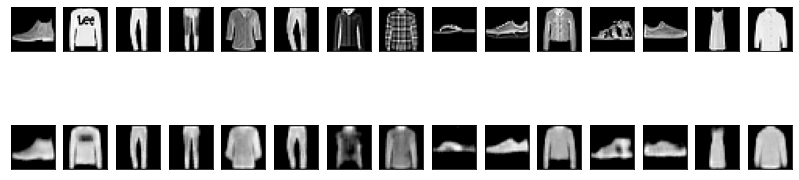

In [7]:
n=15
plt.figure(figsize=(14, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()    

---

Supondo um cenário em que tenhamos muitos exemplos não rotulados:
* aprendemos as características de forma não supervisionada
* utilizamos as características treinando um classificador externo com poucos exemplos rotulados

Para isso, fazemos com que a saída seja a camada do código, e obtemos as predições para o treinamento e o teste

Aqui vamos supor um subconjunto pequeno de dados rotulados

In [8]:
# quantidade de dados rotulados
n_treinamento = 300

code_model = keras.models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense').output)
code_train = np.asarray(code_model.predict(x_train[:n_treinamento]))
code_test  = np.asarray(code_model.predict(x_test))
print("Training data size = ", code_train.shape)
print("Testing data size = ", code_test.shape)

Training data size =  (300, 256)
Testing data size =  (10000, 256)


In [9]:
from sklearn import svm

print('Treinando SVM com ~%d exemplos por classe...' % (n_treinamento//n_classes))
clf = svm.SVC(C=10)
clf.fit(code_train, y_train[:n_treinamento])

Treinando SVM com ~30 exemplos por classe...


SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [10]:
print('Calculando score...')
score = clf.score(code_test, y_test)
print('\nscore: ' + str(score))

Calculando score...

score: 0.7833
